In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from k_means import KMeans  # Replace with correct import if needed


In [2]:

# Load wine data
data = load_wine()
X = data.data

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


Cluster Centers:
 [[-0.92607185 -0.39404154 -0.49451676  0.17060184 -0.49171185 -0.07598265
   0.02081257 -0.03353357  0.0582655  -0.90191402  0.46180361  0.27076419
  -0.75384618]
 [ 0.83523208 -0.30380968  0.36470604 -0.61019129  0.5775868   0.88523736
   0.97781956 -0.56208965  0.58028658  0.17106348  0.47398365  0.77924711
   1.12518529]
 [ 0.16490746  0.87154706  0.18689833  0.52436746 -0.07547277 -0.97933029
  -1.21524764  0.72606354 -0.77970639  0.94153874 -1.16478865 -1.29241163
  -0.40708796]]
Silhouette Score: 0.2848589191898987


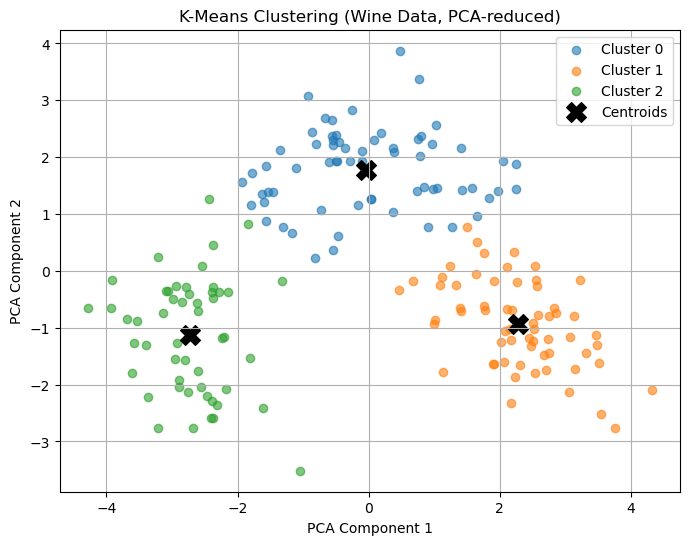

In [3]:

# Apply custom KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Print cluster centers and silhouette score
print("Cluster Centers:\n", kmeans.centroids)
print("Silhouette Score:", kmeans.score(X_scaled))

# Plot clusters
plt.figure(figsize=(8, 6))
for i in range(3):
    cluster_points = X_pca[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}', alpha=0.6)

# Plot centroids (projected)
centroids_pca = pca.transform(kmeans.centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], color='black', marker='X', s=200, label='Centroids')

plt.title("K-Means Clustering (Wine Data, PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()
